## Calorimeter GAN test
### Author: stephen.menary@manchester.ac.uk

---

### Step 1)  Grab a dataset of rings labelled by momentum

---

In [1]:
#  Create simulated dataset of rings and showers
#  -  datapoints are labelled by momentum

import importlib
import Tools.shower_test_tools as tools
tools = importlib.reload(tools)

import numpy as np

num_pixels      = 40
num_simulations = 2000

TRAIN_X, TRAIN_Y, VAL_X, VAL_Y, TEST_X, TEST_Y = tools.get_rings_or_showers_with_coordinates(
    rings=True,
    showers=False,
    do_x=False, 
    do_y=False, 
    do_p=True, 
    num_pixels=num_pixels, 
    num_simulations=num_simulations,
    tag="shower_tests_4p2_ring")

X_Rings = np.concatenate([TRAIN_X, VAL_X, TEST_X])

print(f"   RING DATASET with size {len(X_Rings)}")

'''X1_Shower, Y1_Shower, X2_Shower, Y2_Shower, X3_Shower, Y3_Shower = tools.get_rings_or_showers_with_coordinates(
    rings=False,
    showers=True,
    do_x=False, 
    do_y=False, 
    do_p=True, 
    num_pixels=num_pixels, 
    num_simulations=num_simulations,
    tag="shower_tests_4_shower")

X_Shower = np.concatenate([X1_Shower, X2_Shower, X3_Shower])

print(f"   SHOWER DATASET with size {len(X_Shower)}")'''

2000 rings loaded successfully from file
   RING DATASET with size 2000


'X1_Shower, Y1_Shower, X2_Shower, Y2_Shower, X3_Shower, Y3_Shower = tools.get_rings_or_showers_with_coordinates(\n    rings=False,\n    showers=True,\n    do_x=False, \n    do_y=False, \n    do_p=True, \n    num_pixels=num_pixels, \n    num_simulations=num_simulations,\n    tag="shower_tests_4_shower")\n\nX_Shower = np.concatenate([X1_Shower, X2_Shower, X3_Shower])\n\nprint(f"   SHOWER DATASET with size {len(X_Shower)}")'

---

### Step 2)  Plot some examples of our images

---

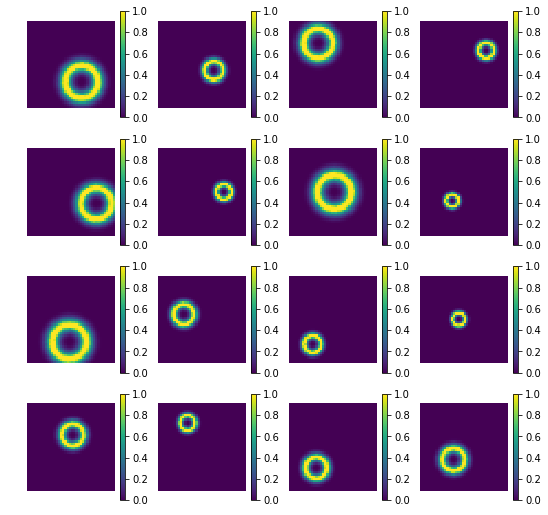

In [2]:
#  Plot some examples of datapoints
#

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(9,9))
for idx, im in enumerate(X_Rings[:16]) :
    plt.subplot(4, 4, 1+idx)
    plt.imshow(im[:,:,0], vmin=0., vmax=1.)
    plt.colorbar()
    plt.axis('off')
plt.show()


---

### Step 3)  Create CNN discriminator, MLP generator and GAN

---

In [3]:
#  Create networks
#

from keras.layers     import Layer, Dense, Flatten, Conv2D, Input, Reshape, LeakyReLU, Dropout, Activation, BatchNormalization, UpSampling2D, Conv2DTranspose
from keras.models     import Model, Sequential
from keras.optimizers import Adam
from tensorflow import reshape
import tensorflow as tf
import keras.backend as K

n_input_size = 100

class Minibatch_discrimination (Layer) :
    def call(self, x):
        c = K.abs(x - K.concatenate([x[-1:], x[:-1]], axis=0))
        return K.concatenate([x, c], axis=1)
    def compute_output_shape(self, input_shape):
        return (input_shape[0], 2*input_shape[1])
    

def create_discriminator_network () :
    model = Sequential(name="Discriminator")
    model.add(Conv2D(12, kernel_size=(3,3), activation="relu", input_shape=(num_pixels, num_pixels, 1)))
    model.add(Dropout(0.3))
    model.add(Conv2D(8, kernel_size=(3,3), activation="relu"))
    model.add(Dropout(0.3))
    model.add(Conv2D(8, kernel_size=(3,3), activation="relu"))
    model.add(Flatten())
    model.add(Dropout(0.3))
    model.add(Dense(256, activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(256, activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation="sigmoid"))
    adam = Adam()
    model.compile(optimizer=adam, loss="binary_crossentropy", metrics=["accuracy"])
    return model

def create_generator_network () :
    model = Sequential(name="Generator")
    model.add(Dense(500, activation="relu", input_shape=(n_input_size,)))
    model.add(Dropout(0.3))
    model.add(BatchNormalization(momentum=0.9))
    model.add(Dense(500, activation="relu"))
    model.add(Dropout(0.3))
    model.add(BatchNormalization(momentum=0.9))
    model.add(Dense(1000, activation="relu"))
    model.add(Dropout(0.3))
    model.add(BatchNormalization(momentum=0.9))
    model.add(Dense(1000, activation="relu"))
    model.add(BatchNormalization(momentum=0.9))
    model.add(Dense(1800, activation="relu"))
    model.add(BatchNormalization(momentum=0.9))
    model.add(Dense(num_pixels*num_pixels, activation="sigmoid"))
    model.add(Reshape(target_shape=(num_pixels, num_pixels, 1)))
    return model

def create_gan(d, g):
    d.trainable = False
    gan = Sequential(name="GAN")
    gan.add(g)
    gan.add(d)
    adam = Adam()
    gan.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    return gan

discriminator = create_discriminator_network()
discriminator.summary()

generator     = create_generator_network()
generator    .summary()

gan           = create_gan(discriminator, generator)
gan          .summary()

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Model: "Discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 38, 38, 12)        120       
_________________________________________________________________
dropout_1 (Dropout)          (None, 38, 38, 12)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 36, 36, 8)         872       
_________________________________________________________________
dropout_2 (Dropout)          (None, 36, 36, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 8)         584       
_________________________________________________________________
flatten_1 (Flatten)          (None, 9248)              0         
_______________________________________________

## Step ) Pre-train the discriminator

In [4]:
'''from keras.callbacks import EarlyStopping

n_showers = int(TRAIN_X.shape[0]/2)
Pretrain_fake = np.concatenate([X1_Shower[:n_showers,:,:,:],
                generator.predict(np.random.normal(0, 1, size=(num_simulations-n_showers, n_input_size)))])
Pretrain_X = np.concatenate([TRAIN_X, Pretrain_fake])
Pretrain_Y = np.concatenate([np.ones(TRAIN_X.shape[0]), np.zeros(Pretrain_fake.shape[0])])

Val_n_showers = int(VAL_X.shape[0]/2)
Val_Pretrain_fake = np.concatenate([X2_Shower[:n_showers,:,:,:],
                    generator.predict(np.random.normal(0, 1, size=(num_simulations-n_showers, n_input_size)))])
Val_Pretrain_X = np.concatenate([VAL_X, Val_Pretrain_fake])
Val_Pretrain_Y = np.concatenate([np.ones(VAL_X.shape[0]), np.zeros(Val_Pretrain_fake.shape[0])])

discriminator.fit(Pretrain_X,
                  Pretrain_Y,
                  validation_data=(Val_Pretrain_X, Val_Pretrain_Y),
                  callbacks=[EarlyStopping(monitor="val_accuracy", restore_best_weights=True, patience=5)],
                  epochs=1000
                  )'''

'from keras.callbacks import EarlyStopping\n\nn_showers = int(TRAIN_X.shape[0]/2)\nPretrain_fake = np.concatenate([X1_Shower[:n_showers,:,:,:],\n                generator.predict(np.random.normal(0, 1, size=(num_simulations-n_showers, n_input_size)))])\nPretrain_X = np.concatenate([TRAIN_X, Pretrain_fake])\nPretrain_Y = np.concatenate([np.ones(TRAIN_X.shape[0]), np.zeros(Pretrain_fake.shape[0])])\n\nVal_n_showers = int(VAL_X.shape[0]/2)\nVal_Pretrain_fake = np.concatenate([X2_Shower[:n_showers,:,:,:],\n                    generator.predict(np.random.normal(0, 1, size=(num_simulations-n_showers, n_input_size)))])\nVal_Pretrain_X = np.concatenate([VAL_X, Val_Pretrain_fake])\nVal_Pretrain_Y = np.concatenate([np.ones(VAL_X.shape[0]), np.zeros(Val_Pretrain_fake.shape[0])])\n\ndiscriminator.fit(Pretrain_X,\n                  Pretrain_Y,\n                  validation_data=(Val_Pretrain_X, Val_Pretrain_Y),\n                  callbacks=[EarlyStopping(monitor="val_accuracy", restore_best_weights

In [5]:
'''gan_val_noise  = np.random.normal(0, 1, size=(2*n_showers, n_input_size))
gan_val_labels = np.array([1 for i in range(2*n_showers)])

replace_generator()

gan.fit(gan_val_noise,
        gan_val_labels,
        callbacks=[EarlyStopping(monitor="accuracy", restore_best_weights=True, patience=5)],
        epochs=1000
        )'''

'gan_val_noise  = np.random.normal(0, 1, size=(2*n_showers, n_input_size))\ngan_val_labels = np.array([1 for i in range(2*n_showers)])\n\nreplace_generator()\n\ngan.fit(gan_val_noise,\n        gan_val_labels,\n        callbacks=[EarlyStopping(monitor="accuracy", restore_best_weights=True, patience=5)],\n        epochs=1000\n        )'

---

### Step 4)  Train the network

---

Epoch 0
Epoch 0: Discriminator accuracy is 71%
Epoch 0: GAN           accuracy is 0%


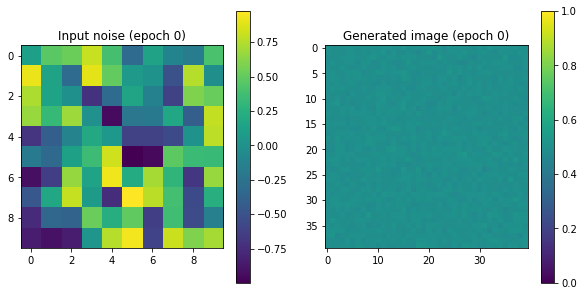

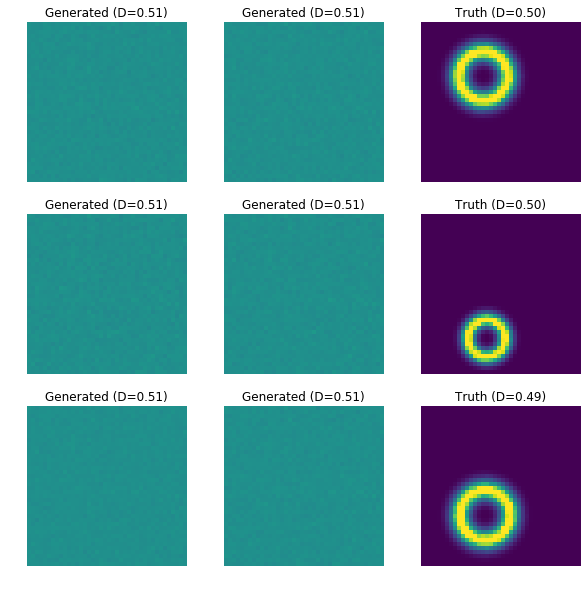

Instructions for updating:
Use tf.cast instead.
Epoch 0: improving Discriminator (attempt 1) with accuracy of 35%               
Epoch 0: improving Discriminator (attempt 2) with accuracy of 50%               
Epoch 0: improving Discriminator (attempt 3) with accuracy of 57%               
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 10: Discriminator accuracy is 75%
Epoch 10: GAN           accuracy is 0%


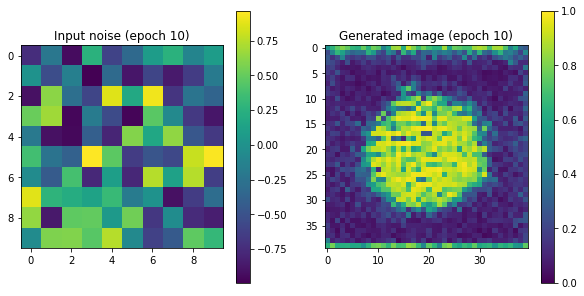

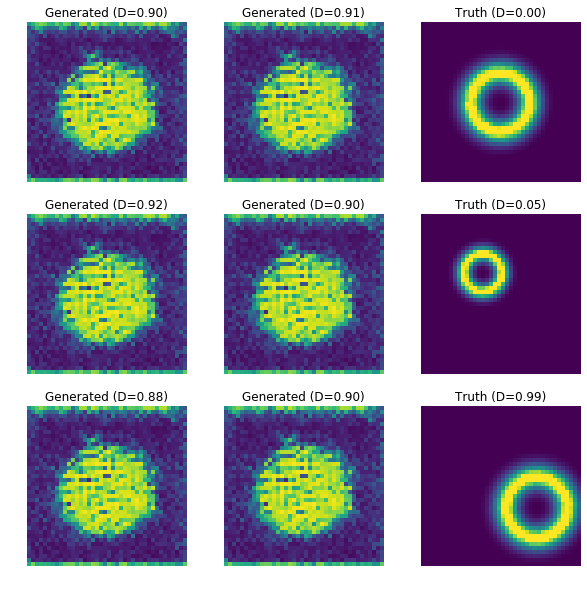

Epoch 10: improving Discriminator (attempt 1) with accuracy of 41%              
Epoch 10: improving Discriminator (attempt 2) with accuracy of 64%              
Epoch 10: improving Discriminator (attempt 3) with accuracy of 63%              
Epoch 10: improving Discriminator (attempt 4) with accuracy of 65%              
Epoch 11
Epoch 12
Epoch 12: improving Discriminator (attempt 1) with accuracy of 60%              
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 20: Discriminator accuracy is 97%
Epoch 20: GAN           accuracy is 0%


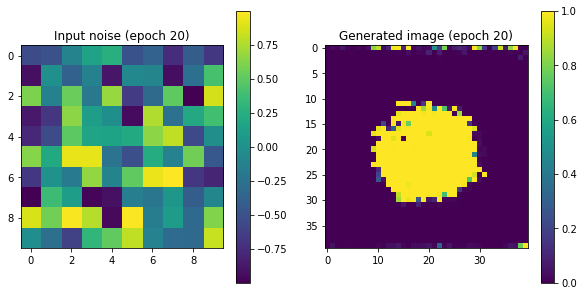

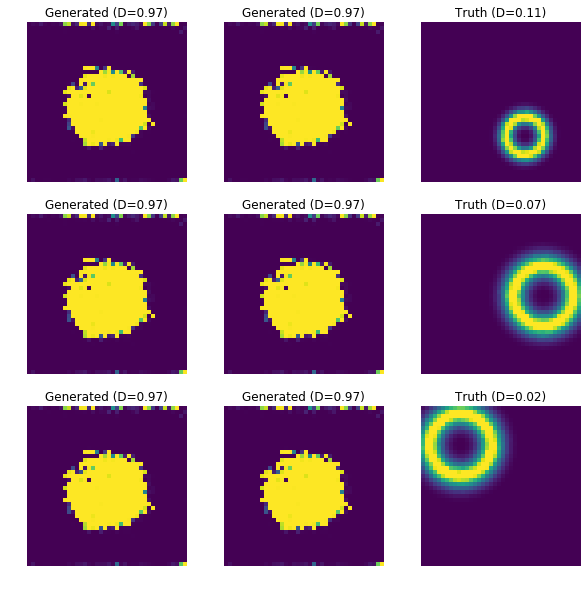

Epoch 20: improving Discriminator (attempt 1) with accuracy of 65%              
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 30: Discriminator accuracy is 98%
Epoch 30: GAN           accuracy is 0%


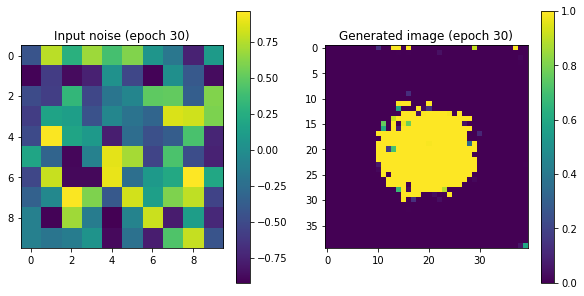

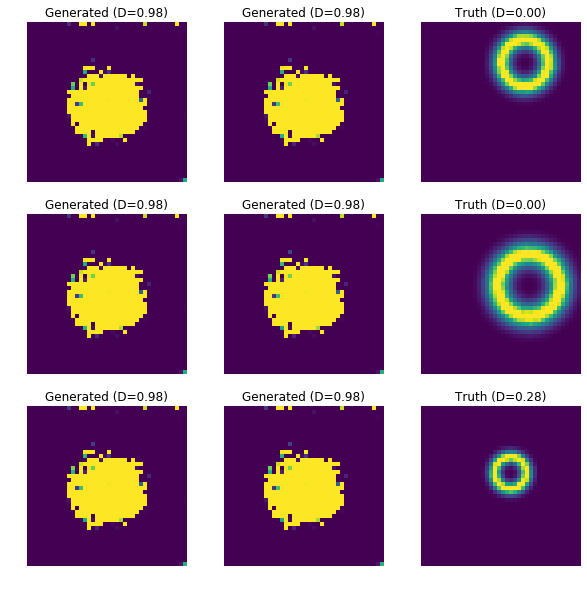

Epoch 30: improving Discriminator (attempt 1) with accuracy of 66%              
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 40: Discriminator accuracy is 99%
Epoch 40: GAN           accuracy is 0%


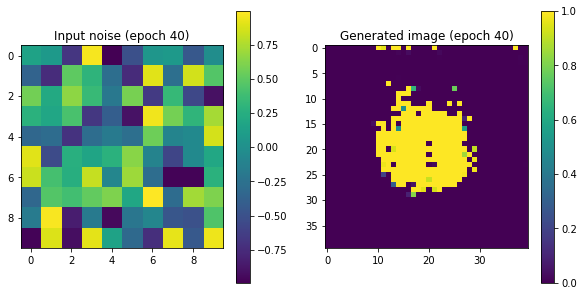

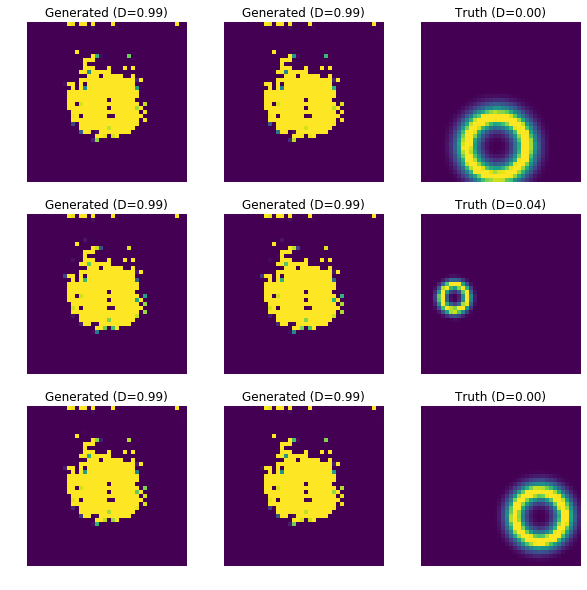

Epoch 40: improving Discriminator (attempt 1) with accuracy of 66%              
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49
Epoch 50
Epoch 50: Discriminator accuracy is 98%
Epoch 50: GAN           accuracy is 0%


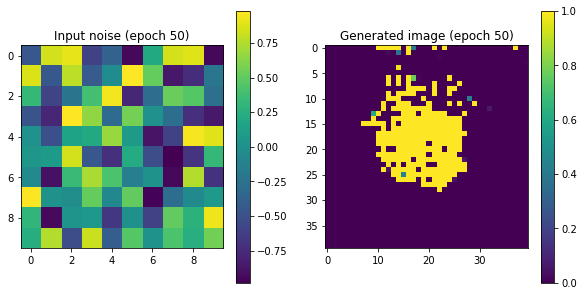

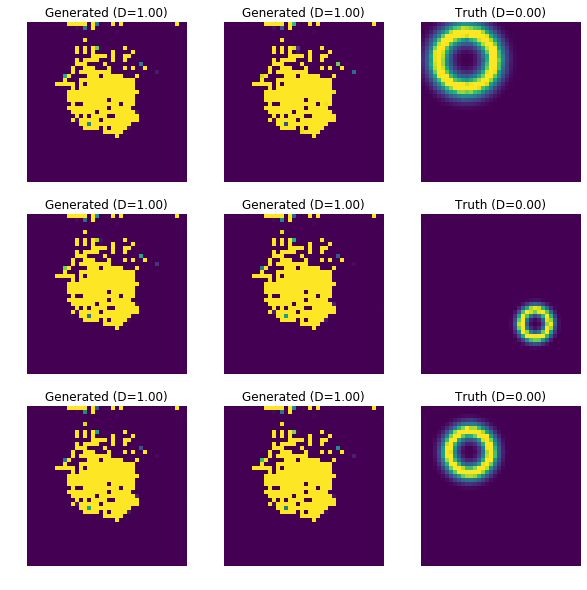

Epoch 50: improving Discriminator (attempt 1) with accuracy of 66%              
Epoch 51
Epoch 52
Epoch 53
Epoch 54
Epoch 55
Epoch 56
Epoch 57
Epoch 58
Epoch 59
Epoch 60
Epoch 60: Discriminator accuracy is 99%
Epoch 60: GAN           accuracy is 0%


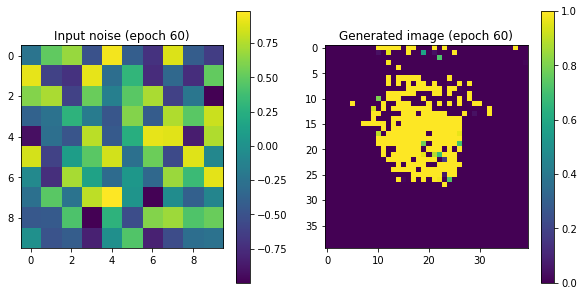

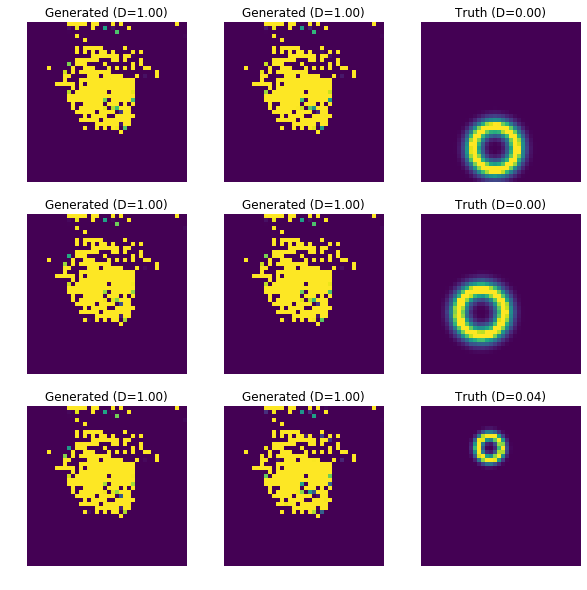

Epoch 60: improving Discriminator (attempt 1) with accuracy of 66%              
Epoch 61
Epoch 62
Epoch 63
Epoch 64
Epoch 65
Epoch 66
Epoch 67
Epoch 68
Epoch 69
Epoch 70
Epoch 70: Discriminator accuracy is 99%
Epoch 70: GAN           accuracy is 0%


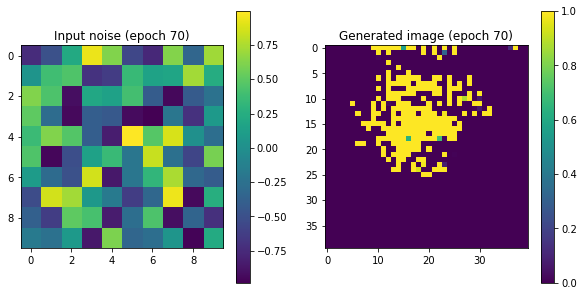

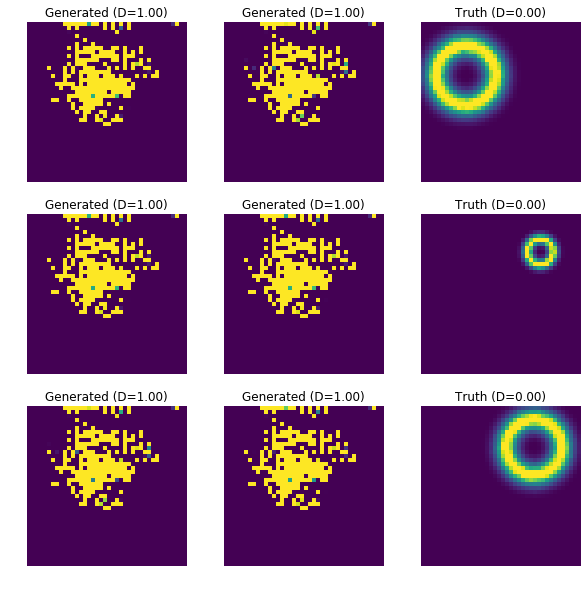

Epoch 70: improving Discriminator (attempt 1) with accuracy of 66%              
Epoch 71
Epoch 72
Epoch 73
Epoch 74
Epoch 75
Epoch 76
Epoch 77
Epoch 78
Epoch 79
Epoch 80
Epoch 80: Discriminator accuracy is 100%
Epoch 80: GAN           accuracy is 0%


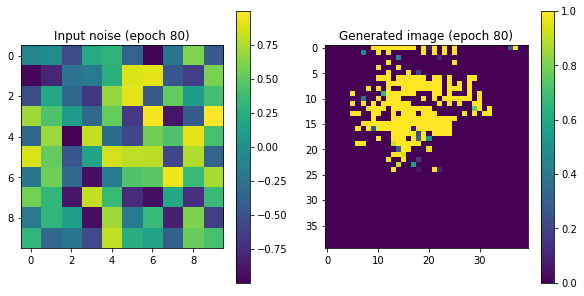

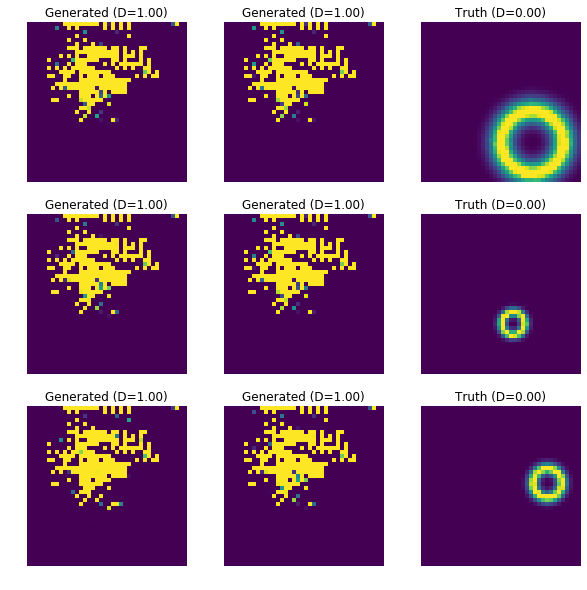

Epoch 80: improving Discriminator (attempt 1) with accuracy of 66%              
Epoch 81
Epoch 82
Epoch 83
Epoch 84
Epoch 85
Epoch 86
Epoch 87
Epoch 88
Epoch 89
Epoch 90
Epoch 90: Discriminator accuracy is 100%
Epoch 90: GAN           accuracy is 0%


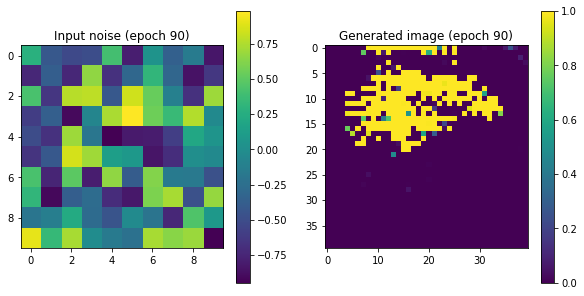

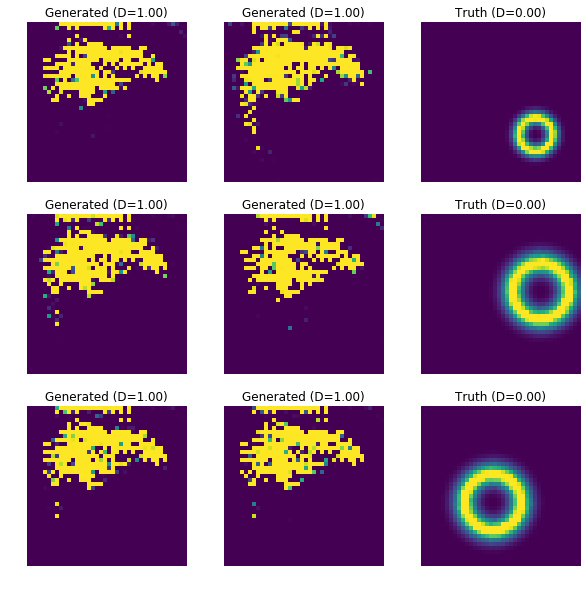

Epoch 90: improving Discriminator (attempt 1) with accuracy of 66%              
Epoch 91
Epoch 92
Epoch 93
Epoch 94
Epoch 95
Epoch 96
Epoch 97
Epoch 98
Epoch 99
Epoch 100
Epoch 100: Discriminator accuracy is 98%
Epoch 100: GAN           accuracy is 0%


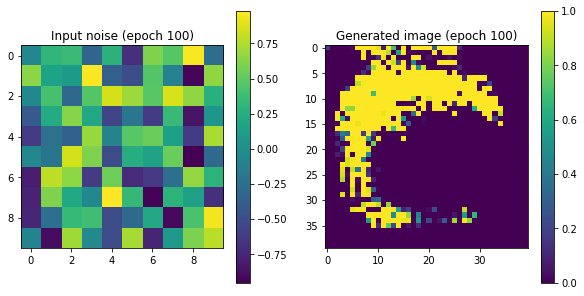

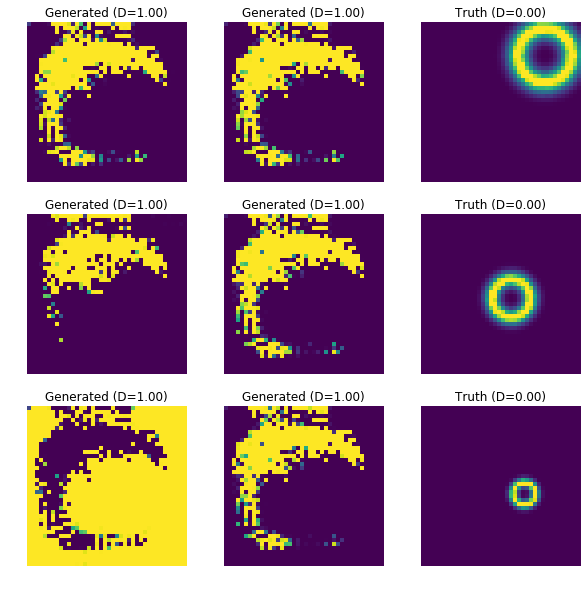

Epoch 100: improving Discriminator (attempt 1) with accuracy of 65%             
Epoch 101
Epoch 102
Epoch 103
Epoch 104
Epoch 105
Epoch 106
Epoch 107
Epoch 108
Epoch 109
Epoch 110
Epoch 110: Discriminator accuracy is 100%
Epoch 110: GAN           accuracy is 0%


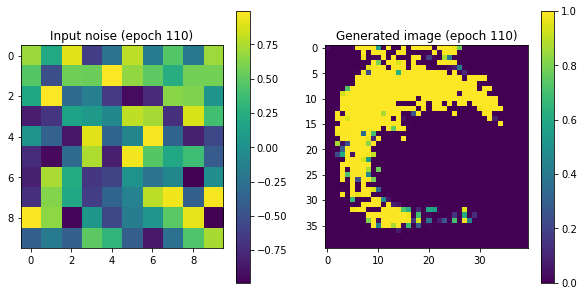

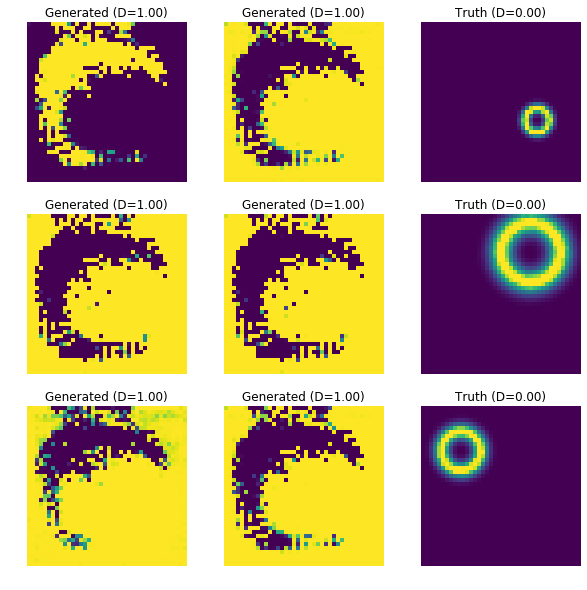

Epoch 110: improving Discriminator (attempt 1) with accuracy of 67%             
Epoch 111
Epoch 112
Epoch 113
Epoch 114
Epoch 115
Epoch 116
Epoch 117


KeyboardInterrupt: 

In [6]:
#  Fit the training data
#  - using early stopping, and storing best solution
#

import sys


def plot_epoch (e, noise, generated_images, image_batch) :
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(121)
    plt.imshow(noise[0,:].reshape(int(np.sqrt(n_input_size)), int(np.sqrt(n_input_size))),)
    plt.title(f"Input noise (epoch {e})")
    plt.colorbar()
    ax = fig.add_subplot(122)
    plt.imshow(generated_images[0,:,:,0], vmin=0., vmax=1.)
    plt.title(f"Generated image (epoch {e})")
    plt.colorbar()
    plt.show()
    
    fig = plt.figure(figsize=(10,10))
    for idx in range(1, 10) :
        ax = fig.add_subplot(330+idx)
        if idx % 3 != 0 : image, label = generated_images[idx-1:idx,:,:,:], "Generated"
        else            : image, label = image_batch     [idx-1:idx,:,:,:], "Truth"
        plt.imshow(image[0,:,:,0], vmin=0., vmax=1.)
        plt.title(f"{label} (D={discriminator.predict(image)[0][0]:.2f})")
        ax.axis("off")
    plt.show()

def training(epochs=1, batch_size=128):
    for e in range(epochs):
        print(f"Epoch {e}")
        
        noise            = np.random.uniform(-1., 1., size=(batch_size, n_input_size))
        generated_images = generator.predict(noise)
        image_batch      = X_Rings[np.random.randint(low=0, high=X_Rings.shape[0], size=batch_size)]
            
        X      = np.concatenate([image_batch, generated_images])
        y_real = np.array([0. for i in range(batch_size)])
        y_gen  = np.array([0. for i in range(batch_size)])
        y_fake = np.array([1. for i in range(batch_size)])
        y_true = np.concatenate([y_real, y_fake])
            
        if e % 10 == 0 :
            print(f"Epoch {e}: Discriminator accuracy is {100.*discriminator.evaluate(X, y_true, verbose=0)[1]:.0f}%")
            print(f"Epoch {e}: GAN           accuracy is {100.*discriminator.evaluate(generated_images, y_gen, verbose=0)[1]:.0f}%")
            plot_epoch(e, noise, generated_images, image_batch)
            
        #Pre train discriminator on  fake and real data  before starting the gan.
        discriminator.trainable=True
        dis_loss, dis_acc = discriminator.train_on_batch(X, y_true)
        
        disc_idx = 0
        while (disc_idx < 10) and (dis_acc < 0.7) :
            print(f"Epoch {e}: improving Discriminator (attempt {disc_idx+1}) with accuracy of {100.*dis_acc:.0f}%".ljust(80))
            dis_loss, dis_acc = discriminator.train_on_batch(X, y_true)
            disc_idx = disc_idx + 1
        '''if disc_idx > 99 and dis_acc < 1e-5 :
            print("-- Replacing discriminator --")
            replace_discriminator()'''
            
        # During the training of gan, the weights of discriminator should be fixed. 
        discriminator.trainable=False
        noise             = np.random.normal(0, 1, size=(batch_size, n_input_size))
        gen_loss, gen_acc = gan.train_on_batch(noise, y_gen)
        
        '''gan_idx = 0
        while gan_idx < 2 and (gen_acc < 0.02) :
            print(f"Epoch {e}: improving Generator     (attempt {gan_idx+1}) with accuracy of {100.*gen_acc:.0f}%".ljust(80))
            gen_loss, gen_acc = gan.train_on_batch(noise, y_gen)
            gan_idx = gan_idx + 1'''
        '''if gan_idx > 99 and gen_acc < 1e-5 :
            print("-- Replacing generator --")
            gan = replace_generator()'''
            
            
training(4000, 400)


In [ ]:
plot_noise            = np.random.uniform(-1., 1., size=(9, n_input_size))
plot_image_batch      = X_Rings[np.random.randint(low=0, high=X_Rings.shape[0], size=9)]
        
fig = plt.figure(figsize=(10,10))
for idx in range(1, 10) :
    ax = fig.add_subplot(330+idx)
    image = plot_generated_images[idx-1:idx,:,:,:]
    plt.imshow(image[0,:,:,0], vmin=0., vmax=1.)
    plt.title(f"Generated image (D={discriminator.predict(image)[0][0]:.2f})")
    ax.axis("off")
plt.show()